In [1]:
#imports:
import math
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
#Read Data:

#Take in DT data from our csv file
data = pd.read_csv('GoldWeekly_DT.csv')
data_DT = pd.DataFrame(data)

data_labels = data_DT['Date'].copy()
data_DT = data_DT.drop('Date', axis = 1)


In [3]:
#Preprocessing data:

#Split data for training and testing
X_train, X_Test_Val = train_test_split(data_DT, test_size = 0.4, train_size = 0.6, shuffle = False)
X_test, X_val = train_test_split(X_Test_Val, test_size = 0.5, train_size = 0.5, shuffle = False)
#Removing the labels from the data.
DT_train_labels = X_train['DidWin'].copy()
X_train = X_train.drop('DidWin', axis = 1)
DT_test_labels = X_test['DidWin'].copy()
X_test = X_test.drop('DidWin', axis = 1)
DT_val_labels = X_val['DidWin'].copy()
X_val = X_val.drop('DidWin', axis = 1)


In [4]:
#Performance Assessment

#Create Decision Tree Model for Entropy
def DTClassifier(critiria, dataset, label):
    DT = DecisionTreeClassifier(criterion=critiria)
    DT_Model = DT.fit(X_train, DT_train_labels)
    
    #Predicting against Test data
    results = DT_Model.predict(dataset)
    
    result_df = pd.DataFrame(dataset)
    result_df = result_df.assign(DidWin = label, Predictions = results)
    
    result_df.insert(0, "Date", data_labels)
    display(result_df)
    #Finding Specificity and Sensitivity
    tn, fp, fn, tp = metrics.confusion_matrix(result_df.iloc[:,5], results).ravel()
    spec = tn/(tn + fp)
    sens = tp/(tp + fn)
    print("Specificity is", spec)
    print("Sensitivity is", sens)

    #Finding AUC
    false_Pos, true_Pos, thresh = metrics.roc_curve(result_df.iloc[:,5], results)
    auc = metrics.auc(false_Pos, true_Pos)
    #print("Area Under ROC curve:", auc) #not used for boolean results.

    #Finding F1
    f1_score = metrics.f1_score(result_df.iloc[:,5], results)
    print("F1 Score:", f1_score)
    print("\n")
    
    accuracy = ((tp+tn)/(tp+tn+fp+fn))
    return DT_Model, accuracy

print('Test results:')
test_DT_Model, test_accuracy = DTClassifier('entropy', X_test, DT_test_labels)
print('\nValidation results:')
val_DT_Model, val_accuracy = DTClassifier('entropy', X_val, DT_val_labels)


Test results:


,Date,Trending,5%Change,HighVol,CloseAvg,DidWin,Predictions
626,12/31/2012,0,0,0,0,1,1
627,1/7/2013,0,0,0,0,1,1
628,1/14/2013,0,0,0,1,0,0
629,1/21/2013,0,0,0,0,1,1
630,1/28/2013,0,0,1,1,0,0
...,...,...,...,...,...,...,...
830,11/28/2016,-1,0,1,0,0,0
831,12/5/2016,-1,0,0,0,0,0
832,12/12/2016,-1,0,0,0,0,0
833,12/19/2016,0,0,0,0,1,1


Specificity is 0.719626168224299
Sensitivity is 0.7254901960784313
F1 Score: 0.7184466019417477



Validation results:


,Date,Trending,5%Change,HighVol,CloseAvg,DidWin,Predictions
835,1/2/2017,1,0,0,1,1,1
836,1/9/2017,1,0,0,1,1,1
837,1/16/2017,0,0,0,0,0,1
838,1/23/2017,0,0,1,0,1,1
839,1/30/2017,0,0,1,1,1,0
...,...,...,...,...,...,...,...
1039,11/30/2020,0,0,1,1,1,0
1040,12/7/2020,1,0,0,0,1,1
1041,12/14/2020,0,0,0,1,0,0
1042,12/21/2020,0,0,0,0,1,1


Specificity is 0.6966292134831461
Sensitivity is 0.7166666666666667
F1 Score: 0.7381974248927038





Test Accuracy: 72.25% of our trades are winning trades using this decision tree model.


Validation Accuracy: 70.81% of our trades are winning trades using this decision tree model.



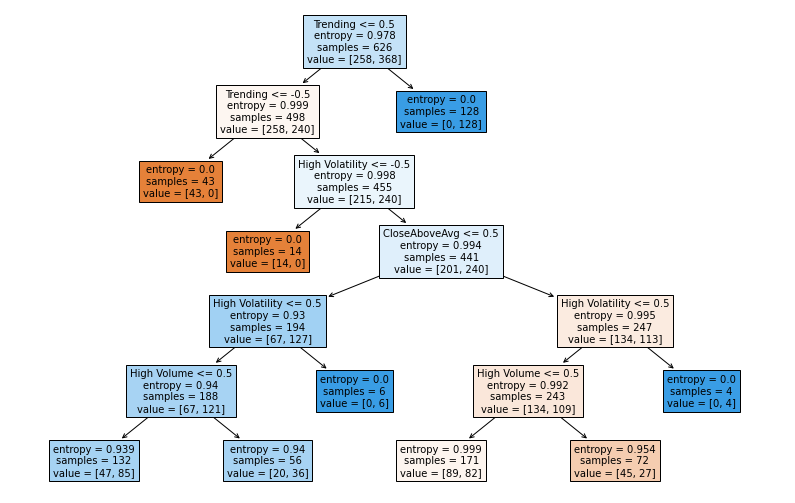

In [5]:
#Model Visualization

print('\nTest Accuracy: ' + str(round((100*test_accuracy), 2)) + '% of our trades are winning trades using this decision tree model.\n')
print('\nValidation Accuracy: ' + str(round((100*val_accuracy), 2)) + '% of our trades are winning trades using this decision tree model.\n')

plt.figure(figsize=(14, 9))
tree.plot_tree(val_DT_Model, filled=True, proportion=False, fontsize=10, feature_names=['Trending','High Volatility','High Volume','CloseAboveAvg'])
plt.show()


While Decision-Trees are great for finding out the biggest contributing factor due to it's easy visualization, they're not the best system for this dataset.
When using Decision-Trees for this dataset, we're unable to find the exact amount of profit or loss from any given trade. It's possible that we're winning 72% of our weekly trades, while our losses are far greater than our gains. 
This system would still work better than keeping money in the bank, though it could easily be improved by comparing the entropy of multiple markets per week and picking the best model for that week. There are some weeks where gold would have a better entropy than silver or platinum, and some weeks it would be better to put your money in silver based on this model.

Explaining our tree plot using our weekly gold market data:
Trending < 0.5 when the market is not uptrending for at least 3-weeks in a row.
Trending < -0.5 when the market is not downtrending for at least 3 weeks.

High Volatility < -0.5 when there's greater than a 5% price drop.
High Volatility < +0.5 when there's greater than a 5% price increase.

CloseAboveAvg = 0 when the weekly price ends below ((weeklyHigh + weeklyLow)/2), and equal to 1 when above.
High Volume = 1 if there was a large amount of volume that week, otherwise it's 0.